In [1]:
%matplotlib inline

# Лабораторная работа №3

In [2]:
from functools import partial
from itertools import islice
from typing import Callable, Generator, Iterable, NamedTuple, List

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from more_itertools import last
from scipy.io import loadmat


def add_free_variable(features: np.ndarray) -> np.ndarray:
    """Adds free variable column to the feature set."""
    return np.insert(features, 0, 1, axis=1)


## Загрузка данных

In [3]:
DATA = loadmat("ex3data1.mat")

X = DATA["X"]
ParamType = X.dtype.type

X_AUGMENTED = add_free_variable(X)

Y = DATA["y"]
Y = np.reshape(Y, (Y.shape[0],))

## Отображение входных данных

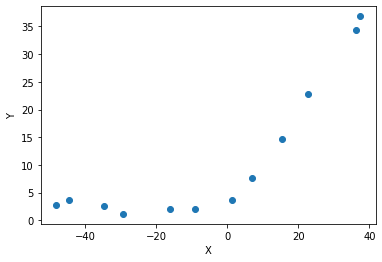

In [4]:
data_fig, data_axes = plt.subplots()

data_axes.scatter(X, Y)
data_axes.set_xlabel("X")
data_axes.set_ylabel("Y")
plt.show()


## Функция потерь с L2-регуляризацией

\begin{equation}
J_r(\theta) =
\frac{1}{2m}
\left [
\sum_{i=1}^m \left (h_\theta (x^{(i)}) - y^{(i)} \right)^2
+ \lambda \sum_{j=2}^n \theta_{j}^2
\right ]
\end{equation}

In [5]:
def loss_regularized(
    theta: np.ndarray, x: np.ndarray, y: np.ndarray, reg_param: ParamType
):
    length = y.shape[0]
    assert length == x.shape[0]
    assert x.shape[1] == theta.shape[0]

    return (
        np.sum(
            np.square(
                np.matmul(x, theta) - y
            )
        ) + reg_param * np.sum(np.square(theta[1:]))
        / (length * 2)
    )


assert 0 == loss_regularized(np.array([1, 2, 3]), np.eye(3), np.array([1, 2, 3]), 0)


## Градиентный спуск с L2-регуляризацией

\begin{align*}
\theta_0 := \theta_0 - \alpha \frac{1}{m}
\sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_0^{(i)} \newline
\theta_j := \theta_j - \alpha
\left [
\frac{1}{m}
\sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}
+ \frac{\lambda}{m} \theta_j
\right ]
& \ \ \ j \in \lbrace 1,2,...n \rbrace
\end{align*}

In [6]:
def gradient_descent_regularized(
    learning_rate: ParamType,
    reg_param: ParamType,
    theta: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    precision: ParamType = ParamType("0.0"),
) -> Generator[np.ndarray, None, None]:
    length = y.shape[0]
    assert length == x.shape[0]
    assert theta.shape[0] == x.shape[1]

    coefficient = learning_rate / length

    lambda_matrix = np.eye(theta.shape[0], dtype=ParamType)
    lambda_matrix[0, 0] = ParamType("0")
    lambda_matrix *= reg_param * coefficient / length

    x_transposed = x.T
    while True:
        new_theta = theta - coefficient * (
            x_transposed @ (np.matmul(x, theta) - y)
        ) - (lambda_matrix @ theta)
        yield new_theta

        if np.allclose(theta, new_theta, atol=precision, rtol=0):
            break

        theta = new_theta


assert np.allclose(
    np.array([1, 2, 3]),
    next(
        gradient_descent_regularized(
            1, 0, np.array([1, 2, 3]), np.eye(3), np.array([1, 2, 3])
        )
    ),
)


## Поиск оптимального значения скорости обучения

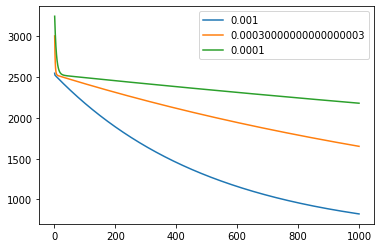

In [7]:
def learning_rate_gen(start=1):
    current_rate = start
    while True:
        yield current_rate
        current_rate /= 10
        yield current_rate * 3


def loss_convergence_display(
    ax: Axes,
    learning_rate: ParamType,
    thetas: Iterable[ParamType],
    loss_for_theta: Callable[[np.ndarray], ParamType],
    max_iterations: int = 100,
):
    loss_values = [loss_for_theta(t) for t in islice(thetas, max_iterations)]
    ax.plot(
        list(range(1, len(loss_values) + 1)),
        loss_values,
        label=str(learning_rate)
    )


ITERATIONS_LIMIT = 1000
THETA_START = np.zeros(X_AUGMENTED.shape[1])

loss_for_theta = partial(
    loss_regularized,
    x=X_AUGMENTED,
    y=Y,
    reg_param=ParamType("0"),
)

learning_rate_fig, learning_rate_axes = plt.subplots()
for rate in islice(learning_rate_gen(1e-3), 3):
    loss_convergence_display(
        ax=learning_rate_axes,
        learning_rate=rate,
        thetas=gradient_descent_regularized(
            learning_rate=rate,
            reg_param=ParamType("0"),
            theta=THETA_START,
            x=X_AUGMENTED,
            y=Y,
        ),
        loss_for_theta=loss_for_theta,
        max_iterations=ITERATIONS_LIMIT,
    )

plt.legend()
plt.show()


### Оптимальное значение скорости обучения

In [8]:
LEARNING_RATE = ParamType("1e-3")

PRECISION = ParamType("1e-6")


## Построение модели с коэффициентом ругуляризации 0

[13.08687393  0.36777305]
9742 iterations


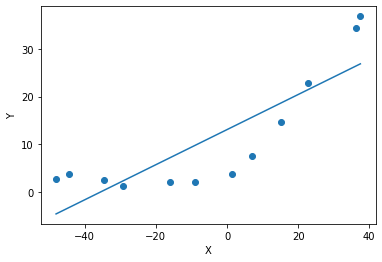

In [9]:
iterations_reg_0, theta_reg_0 = last(
    islice(
        enumerate(
            gradient_descent_regularized(
                learning_rate=LEARNING_RATE,
                reg_param=0,
                theta=THETA_START,
                x=X_AUGMENTED,
                y=Y,
                precision=PRECISION,
            )
        ),
        10000
    )
)

print(theta_reg_0)
print(f"{iterations_reg_0} iterations")

sorted_x = np.sort(X, axis=0)
sorted_x_augmented = np.sort(X_AUGMENTED, axis=0)
sorted_hypotheses = np.matmul(sorted_x_augmented, theta_reg_0)
data_axes.plot(sorted_x, sorted_hypotheses)
data_fig


При коэффициенте регуляризации равном 0, регуляризация не будет работать, так как,
что очевидно из формулы линейной регрессии с L2-регуляризацией, при значении
Lambda = 0, формула эквивалентна обычной линейной регрессии.

## Процесс обучения

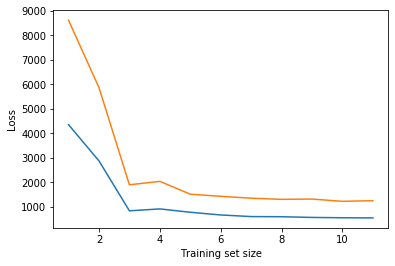

In [21]:
X_VAL = DATA["Xval"]
X_VAL_AUGMENTED = add_free_variable(X_VAL)

Y_VAL = DATA["yval"]
Y_VAL = np.reshape(Y_VAL, (Y_VAL.shape[0],))


class TrainingResult(NamedTuple):
    example_count: int
    theta: np.ndarray
    loss_train: ParamType
    loss_val: ParamType


def learning_curve_graph(
    ax: Axes,
    training_results: List[TrainingResult],
):
    """Display learning curve for training and validation sets."""
    example_counts = [r.example_count for r in training_results]
    ax.plot(
        example_counts,
        [r.loss_train for r in training_results],
        label="Training Set",
    )
    ax.plot(
        example_counts,
        [r.loss_val for r in training_results],
        label="Validation Set",
    )


def learning_curve_results(
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_val: np.ndarray,
    y_val: np.ndarray,
    theta_start: np.ndarray,
    learning_rate: ParamType,
    reg_param: ParamType,
    precision: ParamType = ParamType("0"),
    max_iterations: int = 1000,
) -> List[TrainingResult]:
    res = []
    for example_count in range(1, len(x_train)):
        features = x_train[:example_count]
        results = y_train[:example_count]
        theta = last(
            islice(
                gradient_descent_regularized(
                    theta=theta_start,
                    learning_rate=learning_rate,
                    reg_param=reg_param,
                    x=features,
                    y=results,
                    precision=precision,
                ),
                max_iterations,
            )
        )
        loss_train = loss_regularized(theta, x_train, y_train, reg_param)
        loss_val = loss_regularized(theta, x_val, y_val, reg_param)
        res.append(TrainingResult(example_count, theta, loss_train, loss_val))
    return res


MAX_ITERATIONS = 10000
REG_PARAM = ParamType("0")

learning_curve_fig, learning_curve_axes = plt.subplots()

learning_curve_graph(
    learning_curve_axes,
    learning_curve_results(
        x_train=X_AUGMENTED,
        y_train=Y,
        x_val=X_VAL_AUGMENTED,
        y_val=Y_VAL,
        theta_start=THETA_START,
        learning_rate=LEARNING_RATE,
        reg_param=REG_PARAM,
        precision=PRECISION,
        max_iterations=MAX_ITERATIONS
    )
)

plt.xlabel("Training set size")
plt.ylabel("Loss")
plt.show()


Из графика выше можно сделать вывод, что при увеличении обучающей выборки значение
функции стоимости на валидационной выборке убывает и постепенно сближается
со значением, полученном на обучающей выборке.

## Добавление новых признаков

In [11]:
def extend_feature_set(features: np.ndarray, degree: int) -> np.ndarray:
    for i in range(2, degree + 1):
        powers = np.power(features[:, 0], i)
        powers = np.reshape(powers, (len(powers), 1))
        features = np.append(features, powers, axis=1)
    return features


EXTENDED_FEATURE_SET = extend_feature_set(X, 8)
EXTENDED_VAL_FEATURES = extend_feature_set(X_VAL, 8)



## Нормализация признаков

\begin{equation}
x_i := \frac{x_i - \mu_i}{s_i},\\
\text{где } x_i \text{- признак i}\\
\mu_i - \text{среднее значение признака}\\
s_i - \text{среднеквадратичное отклонение}
\end{equation}

In [12]:
def scale_features(features: np.ndarray) -> np.ndarray:
    return (features - np.mean(features, axis=0)) / np.std(features, axis=0)

EXTENDED_VAL_FEATURES_AUGMENTED = add_free_variable(scale_features(EXTENDED_VAL_FEATURES))
SCALED_FEATURES = scale_features(EXTENDED_FEATURE_SET)
print(SCALED_FEATURES[:3])

[[-3.78243704e-01 -7.88662325e-01  1.90328720e-01 -7.37591303e-01
   3.20251970e-01 -6.17151602e-01  3.59835014e-01 -5.31091256e-01]
 [-8.38920100e-01  1.31420204e-03 -2.58961742e-01 -3.41564822e-01
   9.75492734e-02 -4.55196644e-01  2.66773432e-01 -4.68873807e-01]
 [ 1.43871736e+00  6.10831582e-01  1.30534069e+00  2.56220001e-01
   1.02186338e+00 -1.26962121e-02  7.90210009e-01 -1.77926980e-01]]


## Выбор оптимального значения скорости обучения

In [13]:
FEATURES = add_free_variable(SCALED_FEATURES)
EXTENDED_THETA_START = np.zeros(FEATURES.shape[1])

ITERATIONS_LIMIT = 1000

loss_for_theta = partial(
    loss_regularized,
    x=FEATURES,
    y=Y,
    reg_param=ParamType("0"),
)

learning_rate_fig, learning_rate_axes = plt.subplots()
for rate in islice(learning_rate_gen(1e-2), 3):
    loss_convergence_display(
        ax=learning_rate_axes,
        learning_rate=rate,
        thetas=gradient_descent_regularized(
            learning_rate=rate,
            reg_param=ParamType("0"),
            theta=EXTENDED_THETA_START,
            x=FEATURES,
            y=Y,
        ),
        loss_for_theta=loss_for_theta,
        max_iterations=ITERATIONS_LIMIT,
    )

plt.legend()
plt.show()
EXTENDED_LEARNING_RATE = ParamType("3e-3")


## Обучение модели на расширенном наборе признаков

In [22]:
extended_learning_curve_fig, extended_learning_curve_axes = plt.subplots()

learning_curve_graph(
    extended_learning_curve_axes,
    learning_curve_results(
        x_train=FEATURES,
        y_train=Y,
        x_val=EXTENDED_VAL_FEATURES_AUGMENTED,
        y_val=Y_VAL,
        theta_start=EXTENDED_THETA_START,
        learning_rate=EXTENDED_LEARNING_RATE,
        reg_param=REG_PARAM,
        precision=PRECISION,
        max_iterations=MAX_ITERATIONS,
    )
)

plt.xlabel("Training set size")
plt.ylabel("Loss")
plt.legend()
plt.show()


Из графика выше можно сделать вывод, что для получения корректных результатов
при помощи линейной регрессии на расширенной обучающей выборке, большую роль играет
количество примеров в этой выборке, а также, что увеличение выборки положительно
влияет на качество работы модели.

## График модели
### Регуляризационный параметр = 0

[11.21758933 10.97133512  7.10710649  2.19132732  1.49945765  0.22621993
 -0.15070897  0.3233044  -0.89515214]
10000 iterations


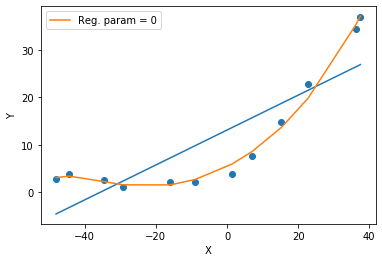

In [15]:
it_extended_reg_0, theta_extended_reg_0 = last(
    enumerate(
        islice(
            gradient_descent_regularized(
                learning_rate=EXTENDED_LEARNING_RATE,
                reg_param=ParamType("0"),
                theta=EXTENDED_THETA_START,
                x=FEATURES,
                y=Y,
                precision=PRECISION,
            ),
            MAX_ITERATIONS
        ),
        1
    )
)

print(theta_extended_reg_0)
print(f"{it_extended_reg_0} iterations")
sorted_features = add_free_variable(
    scale_features(
        extend_feature_set(sorted_x, 8)
    )
)
data_axes.plot(
    sorted_x,
    np.matmul(sorted_features, theta_extended_reg_0),
    label="Reg. param = 0",
)
data_axes.legend()
data_fig


### Регуляризационный параметр = 1

[11.21758933 10.61616669  6.81892577  2.38554385  1.61723477  0.44399977
  0.0313157   0.43366407 -0.70400657]
10000 iterations


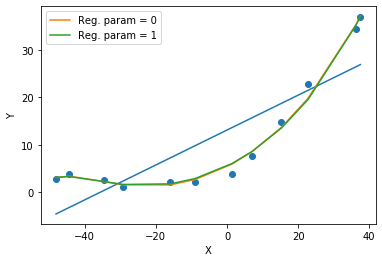

In [16]:
it_extended_reg_1, theta_extended_reg_1 = last(
    enumerate(
        islice(
            gradient_descent_regularized(
                learning_rate=EXTENDED_LEARNING_RATE,
                reg_param=ParamType("1"),
                theta=EXTENDED_THETA_START,
                x=FEATURES,
                y=Y,
                precision=PRECISION,
            ),
            MAX_ITERATIONS
        ),
        1
    )
)

print(theta_extended_reg_1)
print(f"{it_extended_reg_1} iterations")
sorted_features = add_free_variable(
    scale_features(
        extend_feature_set(sorted_x, 8)
    )
)
data_axes.plot(
    sorted_x,
    np.matmul(sorted_features, theta_extended_reg_1),
    label="Reg. param = 1"
)
data_axes.legend()
data_fig


### Регуляризационный параметр = 100

[11.21725759  4.68835761  2.63222953  3.03256962  1.64217271  1.91570986
  0.99385454  1.20747756  0.57776568]
3471 iterations


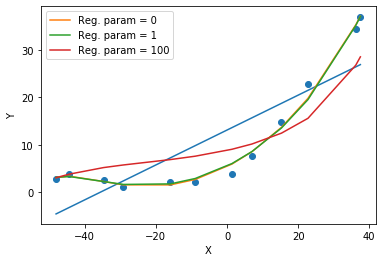

In [17]:
it_extended_reg_100, theta_extended_reg_100 = last(
    enumerate(
        islice(
            gradient_descent_regularized(
                learning_rate=EXTENDED_LEARNING_RATE,
                reg_param=ParamType("100"),
                theta=EXTENDED_THETA_START,
                x=FEATURES,
                y=Y,
                precision=PRECISION,
            ),
            MAX_ITERATIONS
        ),
        1
    )
)

print(theta_extended_reg_100)
print(f"{it_extended_reg_100} iterations")
sorted_features = add_free_variable(
    scale_features(
        extend_feature_set(sorted_x, 8)
    )
)
data_axes.plot(
    sorted_x,
    np.matmul(sorted_features, theta_extended_reg_100),
    label="Reg. param = 100"
)
data_axes.legend()
data_fig


Из графиков представленных выше можно сделать вывод о том, что значение
регуляризационного параметра равное 1 для данной задачи практически не влияет на
сложность полученной модели, которая подвергается переобучению. В то же время
значение регуляризационного параметра равное 100 слишком велико - полученная модель
не соответствует входным данным (недообучение).

## Подбор регуляризационного параметра

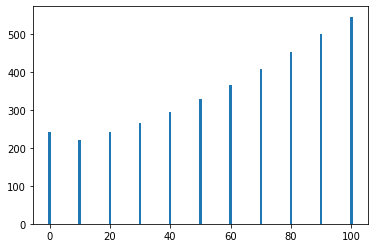

In [18]:
reg_params = [ParamType(i) for i in range(0, 101, 10)]
thetas = [
    last(
        islice(
            gradient_descent_regularized(
                learning_rate=EXTENDED_LEARNING_RATE,
                reg_param=r,
                theta=EXTENDED_THETA_START,
                x=FEATURES,
                y=Y,
                precision=PRECISION
            ),
            MAX_ITERATIONS
        )
    )
    for r in reg_params
]

plt.bar(
    reg_params,
    [
        loss_regularized(theta, EXTENDED_VAL_FEATURES_AUGMENTED, Y_VAL, reg_param)
        for theta, reg_param in zip(thetas, reg_params)
    ],
)
plt.show()

### Оптимальное значение регуляризационного параметра

[11.21758933  8.59708313  5.25171139  3.32543712  2.14796232  1.53956595
  0.91824567  0.98944019  0.25026944]
10000 iterations
Validation loss = 221.80552925774515


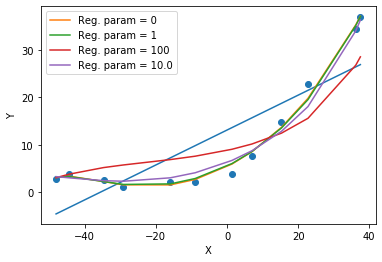

In [19]:
OPTIMAL_REG_PARAM = ParamType("10")

it_extended_reg_opt, theta_extended_reg_opt = last(
    enumerate(
        islice(
            gradient_descent_regularized(
                learning_rate=EXTENDED_LEARNING_RATE,
                reg_param=OPTIMAL_REG_PARAM,
                theta=EXTENDED_THETA_START,
                x=FEATURES,
                y=Y,
                precision=PRECISION,
            ),
            MAX_ITERATIONS
        ),
        1
    )
)

print(theta_extended_reg_opt)
print(f"{it_extended_reg_opt} iterations")
print(
    "Validation loss = {}".format(
        loss_regularized(
            theta_extended_reg_opt,
            EXTENDED_VAL_FEATURES_AUGMENTED,
            Y_VAL,
            OPTIMAL_REG_PARAM
        )
    )
)


sorted_features = add_free_variable(
    scale_features(
        extend_feature_set(sorted_x, 8)
    )
)
data_axes.plot(
    sorted_x,
    np.matmul(sorted_features, theta_extended_reg_opt),
    label=f"Reg. param = {OPTIMAL_REG_PARAM}"
)
data_axes.legend()
data_fig